In [1]:
import os 

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install transformers
!pip install tensorflow
!pip install tensorflow_addons

In [3]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

In [ ]:
MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [5]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print("GPU 작동 중")
  mirrored_strategy = tf.distribute.MirroredStrategy()
else:
  print("GPU 미작동 중")

GPU 작동 중


In [8]:
dataset = pd.read_csv('/content/naver_shopping.csv')
del dataset['Unnamed: 0']
dataset.head()

,label,text
0,1,배공빠르고 굿
1,0,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,1,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,0,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,1,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [9]:
# 데이터셋 파일 및 타입 확인
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   200000 non-null  int64 
 1   text    200000 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [10]:
# 중복 데이터 및 한글 제외 삭제
dataset['text'] = dataset['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
dataset['text'].replace('', np.nan, inplace=True)

dataset['text'].nunique()
dataset.drop_duplicates(subset=['text'], inplace=True)

<ipython-input-10-6f52df5f81d6>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['text'] = dataset['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


Text(0, 0.5, 'Number')

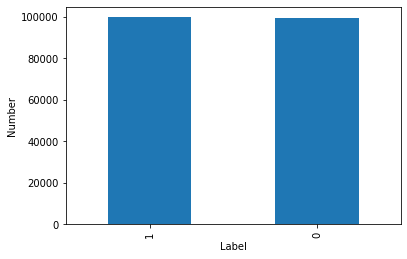

In [11]:
dataset['label'].value_counts().plot(kind = 'bar')
plt.xlabel("Label")
plt.ylabel("Number")

In [13]:
# 긍정 50%, 부정 50%
dataset['label'].value_counts(normalize = True)

1    0.500399
0    0.499601
Name: label, dtype: float64

In [14]:
X_data = dataset['text']
y_data = dataset['label']

TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 42
# strtify = True 일 경우, 데이터 분리 이전의 라벨별 분포 고려
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE, 
                                                    stratify = y_data)

In [15]:
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 159512
테스트 입력 데이터 개수: 39879


In [18]:
# 훈련 데이터 라벨별 비율
y_train.value_counts(normalize = True)

1    0.500401
0    0.499599
Name: label, dtype: float64

In [17]:
# 테스트 데이터 라벨별 비율
y_test.value_counts(normalize = True)

1    0.500389
0    0.499611
Name: label, dtype: float64

In [19]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 80

In [20]:

def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []
    
    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
        
        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        
        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [21]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

159512it [01:36, 1648.29it/s]


In [22]:
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

39879it [00:18, 2123.18it/s]


In [23]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [24]:
bert_outputs

TFSequenceClassifierOutput(loss=None, logits=<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'tf_bert_for_sequence_classification')>, hidden_states=None, attentions=None)

In [25]:
bert_output = bert_outputs[0]

In [26]:
DROPOUT_RATE = 0.5
NUM_CLASS = 2
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [27]:
# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS, 
                                          warmup_proportion = WARMUP_PROPORTION, 
                                          min_lr = MIN_LR, 
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [28]:
# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer, 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        metrics = ['accuracy'])

In [29]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_accuracy", 
    min_delta = MIN_DELTA,
    patience = PATIENCE)

In [30]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = './content/best_model.h5'

In [31]:
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

In [32]:
callbacks = [early_stopping, model_checkpoint]

In [33]:
EPOCHS = 100
BATCH_SZIE = 32

In [ ]:
sentiment_model.fit(train_x, train_y, 
                    epochs = EPOCHS, 
                    shuffle = True, 
                    batch_size = BATCH_SZIE, 
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

In [36]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model('/content/content/best_model.h5',
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [37]:
# 모델이 예측한 라벨 도출
predicted_value = sentiment_model_best.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

1247/1247 [==============================] - 239s 184ms/step


In [39]:
# Classification Report 저장
CL_REPORT_FILE = "./content/cl_report.csv"

cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df.to_csv(CL_REPORT_FILE)
print(cl_report_df)

              precision  recall  f1-score    support
0                 0.943   0.931     0.937  19924.000
1                 0.932   0.944     0.938  19955.000
accuracy          0.937   0.937     0.937      0.937
macro avg         0.938   0.937     0.937  39879.000
weighted avg      0.938   0.937     0.937  39879.000


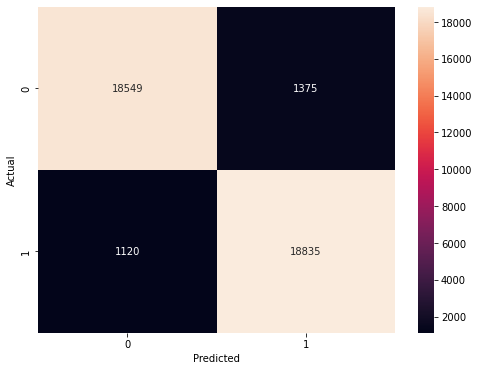

In [40]:
# 이미지 파일 저장정보
FIGURE_FILE = "./content/cf_matrix.png"

cf_matrix = confusion_matrix(test_y, predicted_label)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(FIGURE_FILE)
plt.show()

In [45]:
accuracy_score_v = round(accuracy_score(y_test, predicted_label), 2) # Accuracy
precision_score_v = round(precision_score(y_test, predicted_label, average="weighted"), 2) # Precision
recall_score_v = round(recall_score(y_test, predicted_label, average="weighted"), 2) # Recall
f1_score_v = round(f1_score(y_test, predicted_label, average="weighted"), 2) # F1 Score
cohen_kappa_score_v = round(cohen_kappa_score(y_test, predicted_label), 2) # Cohen's Kappa Score
matthews_corrcoef_v = round(matthews_corrcoef(y_test, predicted_label), 2) # Matthew's Correlation Coefficient
log_loss_v = round(log_loss(y_test, predicted_value), 2) # Log Loss

In [46]:
# 평가지표 결과 저장
METRIC_FILE = './content/metric.csv'

metric_total = pd.DataFrame({
    'PLM': MODEL_NAME,
    'Optimizer': OPTIMIZER_NAME,
    'Accuracy': accuracy_score_v,
    'Precision': precision_score_v,
    'Recall': recall_score_v,
    'F1_score': f1_score_v,
    'Cohen_kappa_coef': cohen_kappa_score_v,
    'Matthews_corrcoef': matthews_corrcoef_v,
    'Log_loss': log_loss_v},
    index = ['-']
    )

In [47]:
metric_total.to_csv(METRIC_FILE)